In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
d1=pd.read_csv('AirPassengers.csv')

In [3]:
d1 = d1.set_index('Month')

In [4]:
d1.index = pd.to_datetime(d1.index)

In [5]:
d1

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


# Train-Test Split

In [6]:
len(d1)

144

In [7]:
144-12

132

In [8]:
train=d1.iloc[:132]
test=d1.iloc[132:]

In [9]:
len(test)

12

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler=MinMaxScaler()

In [12]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [13]:
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [14]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [15]:
n_input=12
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [16]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

In [17]:
model=Sequential()
model.add(LSTM(150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit_generator(generator,epochs=30)

Epoch 1/30
120/120 [==============================] - 1s 9ms/step - loss: 0.0308
Epoch 2/30
120/120 [==============================] - 1s 7ms/step - loss: 0.0133
Epoch 3/30
120/120 [==============================] - 1s 6ms/step - loss: 0.0119
Epoch 4/30
120/120 [==============================] - 1s 7ms/step - loss: 0.0104
Epoch 5/30
120/120 [==============================] - 1s 5ms/step - loss: 0.0097
Epoch 6/30
120/120 [==============================] - 1s 10ms/step - loss: 0.0084
Epoch 7/30
120/120 [==============================] - 1s 5ms/step - loss: 0.0067
Epoch 8/30
120/120 [==============================] - 1s 5ms/step - loss: 0.0047
Epoch 9/30
120/120 [==============================] - 1s 8ms/step - loss: 0.0046
Epoch 10/30
120/120 [==============================] - 1s 5ms/step - loss: 0.0072
Epoch 11/30
120/120 [==============================] - 1s 6ms/step - loss: 0.0057
Epoch 12/30
120/120 [==============================] - 1s 5ms/step - loss: 0.0051
Epoch 13/30
120/120 [===

In [20]:
loss_per_epoch=model.history.history['loss']

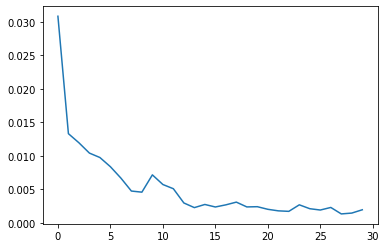

In [21]:
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# Evaluation on test data

In [22]:
first_eval_batch=scaled_train[-12:]

In [23]:
first_eval_batch

array([[0.56263736],
       [0.52307692],
       [0.66373626],
       [0.64175824],
       [0.69450549],
       [0.80879121],
       [0.97582418],
       [1.        ],
       [0.78901099],
       [0.66593407],
       [0.56703297],
       [0.66153846]])

# Generate predictions into the same time stamps as the test sets

In [24]:
test_predictions=[]
first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input,n_features))
for i in range(len(test)):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

# Inverse transformations and compare

In [25]:
true_predictions=scaler.inverse_transform(test_predictions)

In [26]:
test['predictions']=true_predictions

C:\Users\Manoj\anaconda31\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
test

,#Passengers,predictions
Month,,
1960-01-01,417,408.596462
1960-02-01,391,420.121018
1960-03-01,419,456.573597
1960-04-01,461,474.553716
1960-05-01,472,515.282133
1960-06-01,535,597.816205
1960-07-01,622,689.086885
1960-08-01,606,686.623240
1960-09-01,508,575.324464


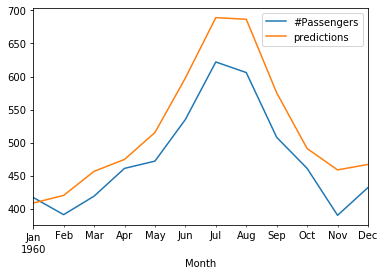

In [28]:
test.plot()

In [29]:
first_eval_batch=test['#Passengers']
true_predictions=pd.DataFrame(true_predictions)

In [30]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
Rmse = np.sqrt(mean_squared_error(first_eval_batch,true_predictions))
Rmse

50.59255090217099

In [31]:
first_eval_batch

Month
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, dtype: int64

In [32]:
df_predict=pd.DataFrame(scaler.inverse_transform(test_predictions),index=d1[-n_input:].index,columns=['Predictions'])
d11=pd.concat([d1,df_predict],axis=1)

In [33]:
d11

,#Passengers,Predictions
Month,,
1949-01-01,112,NaN
1949-02-01,118,NaN
1949-03-01,132,NaN
1949-04-01,129,NaN
1949-05-01,121,NaN
...,...,...
1960-08-01,606,686.623240
1960-09-01,508,575.324464
1960-10-01,461,491.019720


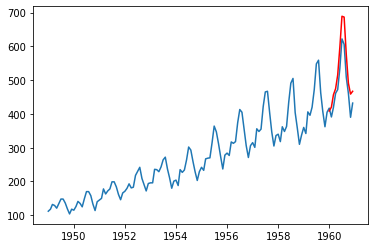

In [34]:
plt.figure()
plt.plot(d1.index,d1['#Passengers'])
plt.plot(d11.index,d11['Predictions'],color='r')

In [35]:
train=d1
scaler.fit(train)
train=scaler.transform(train)
n_input=12
n_features=1
generator=TimeseriesGenerator(train,train,length=n_input,batch_size=1)
model.fit_generator(generator,epochs=30)
test_predictions=[]
first_eval_batch=train[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input,n_features))
for i in range(n_input):
    current_pred=model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

Epoch 1/30
132/132 [==============================] - 1s 5ms/step - loss: 0.0018
Epoch 2/30
132/132 [==============================] - 1s 11ms/step - loss: 0.0023
Epoch 3/30
132/132 [==============================] - 1s 7ms/step - loss: 0.0014
Epoch 4/30
132/132 [==============================] - 1s 5ms/step - loss: 0.0024
Epoch 5/30
132/132 [==============================] - 1s 5ms/step - loss: 0.0020
Epoch 6/30
132/132 [==============================] - 1s 5ms/step - loss: 0.0015
Epoch 7/30
132/132 [==============================] - 1s 5ms/step - loss: 0.0013
Epoch 8/30
132/132 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 9/30
132/132 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 10/30
132/132 [==============================] - 1s 5ms/step - loss: 0.0011
Epoch 11/30
132/132 [==============================] - 1s 6ms/step - loss: 0.0018
Epoch 12/30
132/132 [==============================] - 1s 5ms/step - loss: 0.0015
Epoch 13/30
132/132 [===

In [36]:
from pandas.tseries.offsets import DateOffset
add_dates=[d1.index[-1]+DateOffset(months=x) for x in range(0,13)]
future_dates=pd.DataFrame(index=add_dates[1:],columns=d1.columns)

In [37]:
future_dates.tail(12)

,#Passengers
1961-01-01,NaN
1961-02-01,NaN
1961-03-01,NaN
1961-04-01,NaN
1961-05-01,NaN
1961-06-01,NaN
1961-07-01,NaN
1961-08-01,NaN
1961-09-01,NaN
1961-10-01,NaN


In [38]:
df_predict=pd.DataFrame(scaler.inverse_transform(test_predictions),index=future_dates[-n_input:].index,columns=['Predictions'])
d_proj=pd.concat([d1,df_predict],axis=1)

In [39]:
d_proj.tail(24)

,#Passengers,Predictions
1960-01-01,417.0,NaN
1960-02-01,391.0,NaN
1960-03-01,419.0,NaN
1960-04-01,461.0,NaN
1960-05-01,472.0,NaN
1960-06-01,535.0,NaN
1960-07-01,622.0,NaN
1960-08-01,606.0,NaN
1960-09-01,508.0,NaN
1960-10-01,461.0,NaN


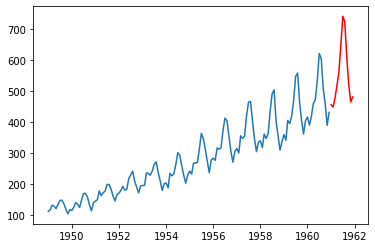

In [40]:
plt.figure()
plt.plot(d_proj.index,d_proj['#Passengers'])
plt.plot(d_proj.index,d_proj['Predictions'],color='r')